In [51]:
pip install pandas numpy scikit-learn seaborn matplotlib shap xgboost catboost lightgbm joblib imbalanced-learn streamlit jupyterlab

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score,roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap

# Color Palette
palette = ['#b8c0ff', '#ffd6a5', '#ffadad', '#caffbf', '#9bf6ff']
sns.set_palette(palette)
sns.set(rc={"axes.facecolor":"#f7e1d7","figure.facecolor":"#f5f5f5"})
cmap = colors.ListedColormap(palette)
%matplotlib inline

In [17]:
!pip install pyxlsb xlrd openpyxl


   ---------------------------------------- 2/2 [xlrd]



In [26]:
import os
print(os.getcwd())

C:\Users\sruth


In [27]:
os.listdir()

['.anaconda',
 '.conda',
 '.condarc',
 '.continuum',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.matplotlib',
 'anaconda3',
 'anaconda_projects',
 'AppData',
 'Application Data',
 'Contacts',
 'Cookies',
 'Documents',
 'Downloads',
 'Favorites',
 'Links',
 'Local Settings',
 'Music',
 'My Documents',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{5b4f4593-1ddf-11f0-89c9-8c47be171a1b}.TxR.0.regtrans-ms',
 'NTUSER.DAT{5b4f4593-1ddf-11f0-89c9-8c47be171a1b}.TxR.1.regtrans-ms',
 'NTUSER.DAT{5b4f4593-1ddf-11f0-89c9-8c47be171a1b}.TxR.2.regtrans-ms',
 'NTUSER.DAT{5b4f4593-1ddf-11f0-89c9-8c47be171a1b}.TxR.blf',
 'NTUSER.DAT{5b4f4594-1ddf-11f0-89c9-8c47be171a1b}.TM.blf',
 'NTUSER.DAT{5b4f4594-1ddf-11f0-89c9-8c47be171a1b}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{5b4f4594-1ddf-11f0-89c9-8c47be171a1b}.TMContainer00000000000000000002.regtrans-ms',
 'ntuser.ini',
 'OneDrive',
 'PrintHood',
 'Recent',
 'Saved Games',
 'Searches',
 'SendTo',
 '

In [29]:
import glob

files = glob.glob(r"C:\Users\sruth\OneDrive\accepted_2007_to_2018Q4.csv", recursive=True)
print(files)

['C:\\Users\\sruth\\OneDrive\\accepted_2007_to_2018Q4.csv']


In [32]:
path = r"C:\Users\sruth\OneDrive\accepted_2007_to_2018Q4.csv"
os.path.exists(path)

True

In [ ]:
df = pd.read_csv(path)
df.head(5)

### Exploratory Data Analysis 

In [103]:


#  prerequisites: temp_target already mapped 0/1 from loan_status ---
# Drop any unmapped rows (NaNs) before stratifying
mask = temp_target.notna()
if mask.sum() != len(temp_target):
    df = df[mask].copy()
    temp_target = temp_target[mask]

n = len(df)
desired = 50_000

if n <= desired:
    # Keep all rows, just shuffle for randomness
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
else:
    frac = desired / n  # float strictly between 0 and 1
    try:
        df, _ = train_test_split(
            df,
            train_size=frac,           
            stratify=temp_target,
            random_state=42,
            shuffle=True,
        )
    except ValueError as e:
        # If a minority class is too small for stratify, fall back to random sample
        print(f"Stratified sampling failed ({e}). Falling back to random sampling.")
        df, _ = train_test_split(
            df,
            train_size=frac,
            random_state=42,
            shuffle=True,
        )

print(f"Final sampled dataset: {df.shape}")
print("Class balance in sample:")
print(df['loan_status_binary'].value_counts(normalize=True).round(3))


Final sampled dataset: (50000, 152)
Class balance in sample:
loan_status_binary
0    0.786
1    0.214
Name: proportion, dtype: float64


In [72]:
status_map = {
    'Fully Paid': 0, 'Charged Off': 1, 'Default': 1, 
    'Late (31-120 days)': 1, 'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Does not meet the credit policy. Status:Charged Off': 1
}

print("\nBinary mapping:")
print("  0: Paid (Fully Paid, Policy-Fully Paid)")
print("  1: Default (Charged Off, Default, Late, Policy-Charged Off)")

df['loan_status_binary'] = df['loan_status'].map(status_map).astype(int)


# Class distribution
class_dist = df['loan_status_binary'].value_counts().sort_index()
print(f"\nClass distribution:")
for cls, count in class_dist.items():
    label = "Paid" if cls == 0 else "Default"
    print(f"  {cls} ({label}): {count:,} ({count/len(df)*100:.1f}%)")
    


Binary mapping:
  0: Paid (Fully Paid, Policy-Fully Paid)
  1: Default (Charged Off, Default, Late, Policy-Charged Off)

Class distribution:
  0 (Paid): 39,280 (78.6%)
  1 (Default): 10,720 (21.4%)


In [61]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status_binary
1649195,385619,NaN,16000.0,16000.0,15632.189855,36 months,12.21,533.04,B,B5,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
58324,65503565,NaN,25300.0,25300.0,25300.000000,36 months,16.55,896.36,D,D2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
347997,43195400,NaN,4000.0,4000.0,4000.000000,36 months,16.99,142.60,D,D3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1200569,24444953,NaN,34550.0,34550.0,34550.000000,60 months,20.20,919.22,E,E3,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1173002,30315154,NaN,12000.0,12000.0,12000.000000,36 months,6.49,367.74,A,A2,...,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0


In [62]:
print("Information About DataSet :")
print(df.info())
print("Count of Missing values:")
print(df.isnull().sum())
print("\nStatistics:")
df.describe()

Information About DataSet :
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 1649195 to 165117
Columns: 152 entries, id to loan_status_binary
dtypes: float64(113), int64(1), object(38)
memory usage: 58.4+ MB
None
Count of Missing values:
id                           0
member_id                50000
loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
                         ...  
settlement_date          48708
settlement_amount        48708
settlement_percentage    48708
settlement_term          48708
loan_status_binary           0
Length: 152, dtype: int64

Statistics:


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,loan_status_binary
count,0.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,49992.000000,49999.000000,50000.000000,...,267.000000,267.0,267.000000,189.000000,267.000000,267.000000,1292.000000,1292.000000,1292.000000,50000.00000
mean,NaN,14518.387000,14508.040000,14482.750484,13.306548,441.596577,7.593417e+04,18.321145,0.313946,695.996100,...,158.838427,3.0,14.685393,472.396825,11638.097640,193.341873,5127.190418,47.450967,13.157895,0.21440
std,NaN,8768.533458,8763.727409,8770.610297,4.808448,263.610471,5.196036e+04,11.302939,0.858982,31.828141,...,150.630081,0.0,9.409556,449.543558,7841.738166,203.781136,3811.704621,6.741879,8.295650,0.41041
min,NaN,1000.000000,1000.000000,0.000000,5.310000,30.120000,0.000000e+00,0.000000,0.000000,640.000000,...,6.890000,3.0,0.000000,20.670000,699.250000,0.010000,226.000000,14.960000,0.000000,0.00000
25%,NaN,8000.000000,8000.000000,8000.000000,9.750000,250.290000,4.598425e+04,11.760000,0.000000,670.000000,...,54.160000,3.0,8.000000,165.300000,6201.725000,44.950000,2228.872500,45.000000,6.000000,0.00000
50%,NaN,12000.000000,12000.000000,12000.000000,12.790000,376.645000,6.500000e+04,17.620000,0.000000,690.000000,...,109.310000,3.0,15.000000,318.930000,9647.450000,122.640000,4301.500000,45.000000,14.000000,0.00000
75%,NaN,20000.000000,20000.000000,20000.000000,16.020000,587.442500,9.000000e+04,24.110000,0.000000,710.000000,...,203.090000,3.0,23.000000,586.590000,15522.410000,286.665000,7019.005000,50.000000,18.000000,0.00000
max,NaN,40000.000000,40000.000000,40000.000000,30.990000,1618.030000,1.500000e+06,999.000000,18.000000,845.000000,...,923.400000,3.0,30.000000,2679.150000,38399.000000,1407.860000,26751.740000,90.000000,36.000000,1.00000


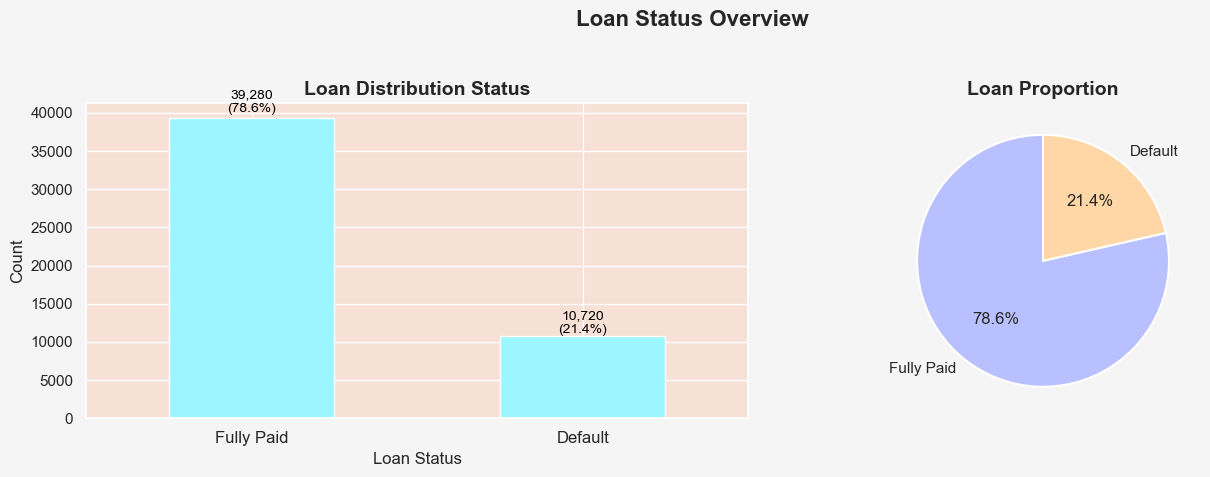


Class Distribution:
  Paid:    39,280 (78.6%)
  Default: 10,720 (21.4%)
  Default Rate: 21.44%
  Total Loans: 50,000


In [83]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
value_counts = df['loan_status_binary'].value_counts().sort_index()
bar_color = palette[-1] if len(palette) >= 1 else 'steelblue'
value_counts.plot(kind='bar', ax=axes[0], color=bar_color)

axes[0].set_title('Loan Distribution Status', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

tick_labels = ['Fully Paid' if i == 0 else 'Default' for i in value_counts.index]
axes[0].set_xticks(range(len(tick_labels)))
axes[0].set_xticklabels(tick_labels, rotation=0, fontsize=12)

# Add count + % labels above bars
for i, v in enumerate(value_counts):
    axes[0].text(i, v + (v * 0.01), f'{v:,}\n({v/df.shape[0]*100:.1f}%)',
                 ha='center', va='bottom', fontsize=10, color='black')

# Pie chart
value_counts.plot(
    kind='pie',
    ax=axes[1],
    autopct='%1.1f%%',
    colors=palette[:len(value_counts)],
    labels=tick_labels,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)
axes[1].set_title('Loan Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

fig.suptitle('Loan Status Overview', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Summary stats
default_rate = df['loan_status_binary'].mean()*100
print(f"\nClass Distribution:")
print(f"  Paid:    {(df['loan_status_binary']==0).sum():,} ({(df['loan_status_binary']==0).mean()*100:.1f}%)")
print(f"  Default: {(df['loan_status_binary']==1).sum():,} ({(df['loan_status_binary']==1).mean()*100:.1f}%)")
print(f"  Default Rate: {default_rate:.2f}%")
print(f"  Total Loans: {len(df):,}")


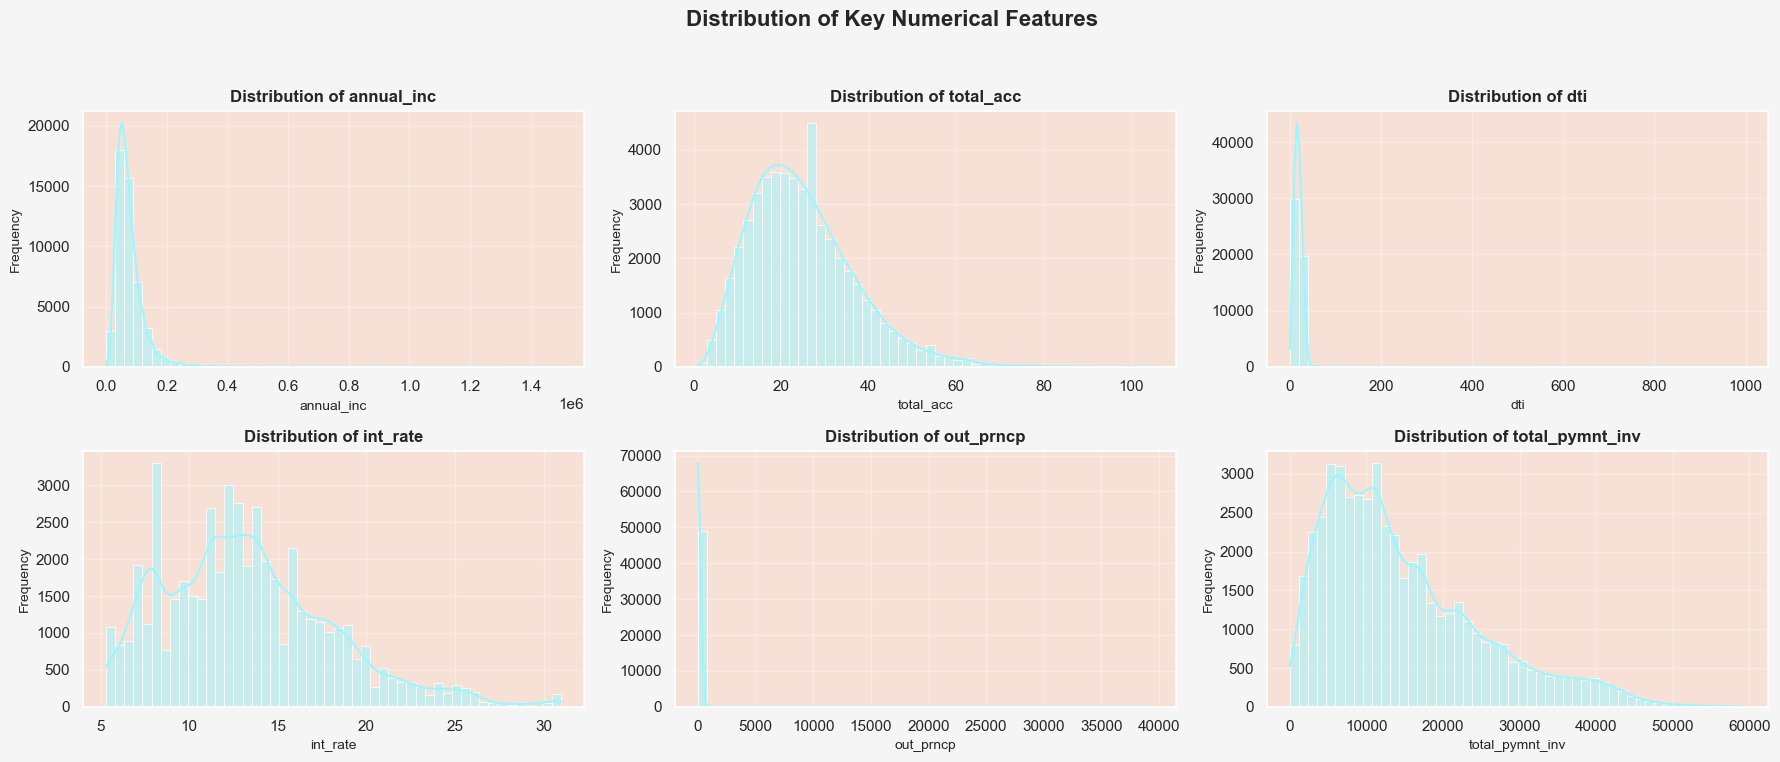

In [117]:
import math
# Select only the columns that actually exist
potential_numericals = [
    'annual_inc', 'total_acc', 'dti', 'int_rate',
    'out_prncp', 'total_pymnt_inv'
]
features = [f for f in potential_numericals if f in df.columns]

# Create grid size automatically (3 columns per row)
n = len(features)
ncols = 3
nrows = math.ceil(n / ncols) if n > 0 else 1

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
axes = np.atleast_1d(axes).ravel()  # flatten axes even if 1 row

for i, col in enumerate(features):
    ax = axes[i]

    # Clean values to numeric safely 
    s = df[col]
    if s.dtype == 'object':
        s = (
            s.astype(str)
             .str.replace('%', '', regex=False)
             .str.replace(' ', '', regex=False)
             .replace('', np.nan)
        )
    s = pd.to_numeric(s, errors='coerce')

    # Ploting
    sns.histplot(
        s.dropna(),
        bins=50,
        kde=True,
        color=palette[-1] if len(palette) else 'steelblue',
        ax=ax
    )

    #  Formatting 
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.grid(alpha=0.3)

#  Remove any unused subplots 
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Distribution of Key Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<Figure size 1200x1000 with 0 Axes>

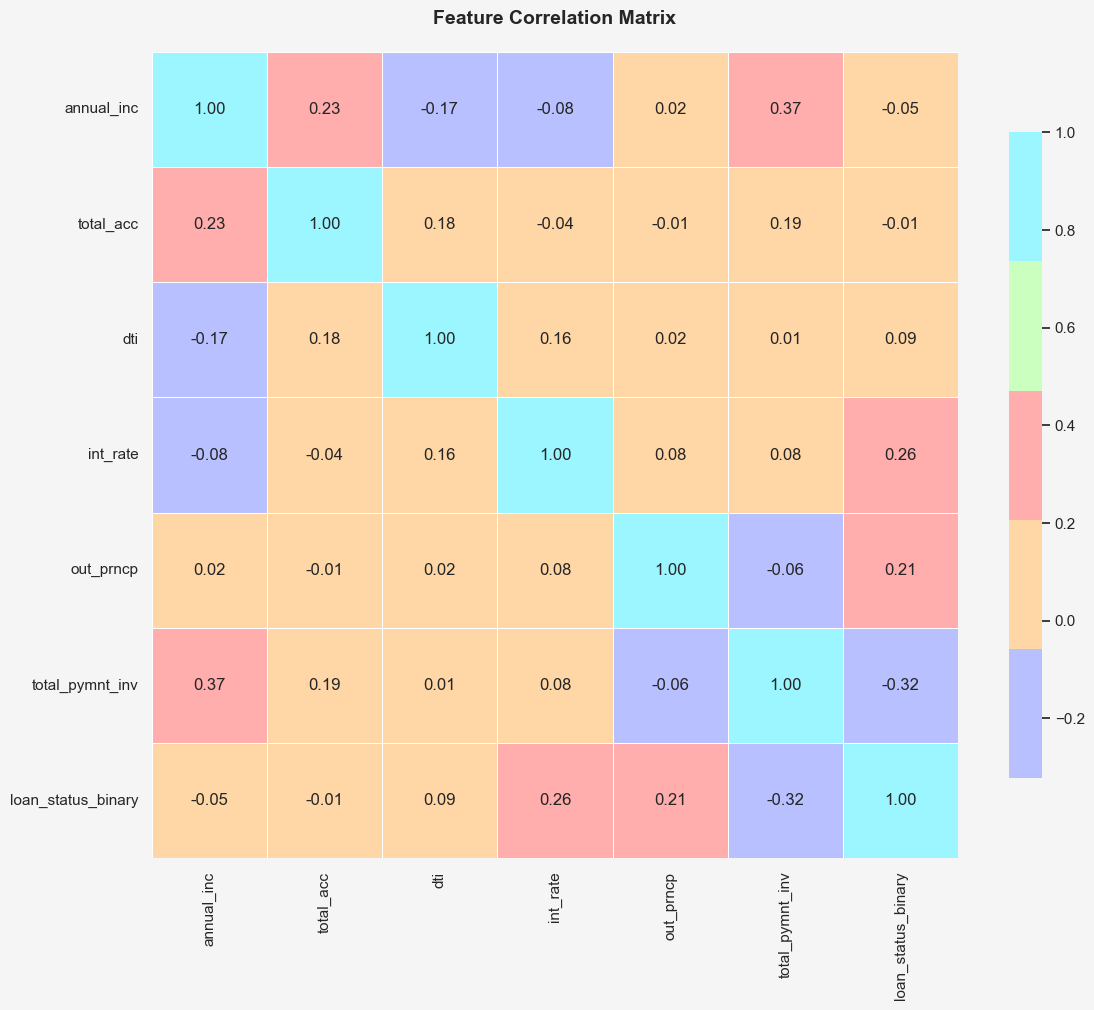

In [125]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[features + ['loan_status_binary']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f',cmap= cmap, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

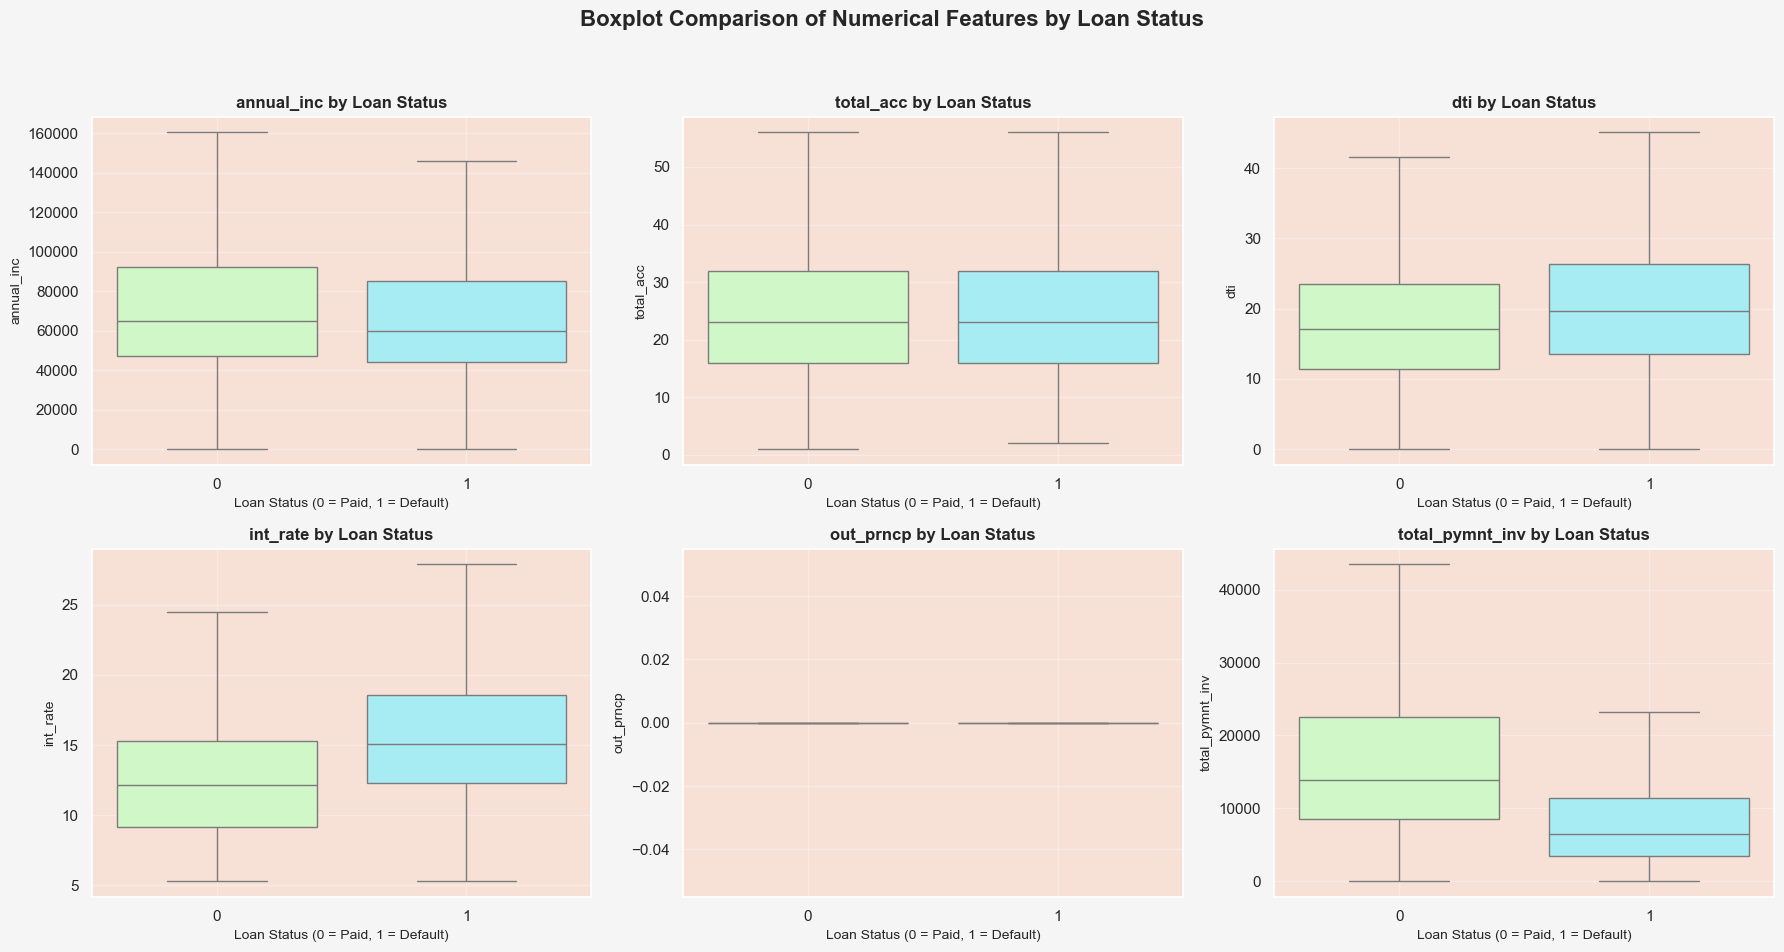

In [130]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(features):
    if idx < len(axes):
        #  Clean numeric column safely
        df[col] = pd.to_numeric(df[col], errors='coerce')

        sns.boxplot(
            x='loan_status_binary',
            y=col,
            data=df,
            palette=[palette[-2], palette[-1]] if len(palette) >= 2 else "Set2",
            ax=axes[idx],
            showfliers=False  # hides extreme outliers for clearer boxes
        )

        axes[idx].set_title(f'{col} by Loan Status', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Loan Status (0 = Paid, 1 = Default)', fontsize=10)
        axes[idx].set_ylabel(col, fontsize=10)
        axes[idx].grid(alpha=0.3)

# --- Remove unused subplots ---
plt.suptitle('Boxplot Comparison of Numerical Features by Loan Status', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Data Processing 

In [132]:
# STEP 1: CLEAN RAW FIELDS 
# Interest rate: '13.5%' -> 0.135

if 'int_rate' in df.columns:
    df['int_rate'] = (
        df['int_rate'].astype(str).str.strip()
          .str.replace('%', '', regex=False)
          .replace(['', 'nan'], np.nan)
    )
    df['int_rate'] = pd.to_numeric(df['int_rate'], errors='coerce') / 100

# Revolving utilization: '85.5%' -> 85.5  
if 'revol_util' in df.columns:
    df['revol_util'] = (
        df['revol_util'].astype(str).str.strip()
          .str.replace('%', '', regex=False)
          .replace(['', 'nan'], np.nan)
    )
    df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce')

# Employment length: '10+ years' -> 10 , '< 1 year' -> 0
if 'emp_length' in df.columns:
    df['emp_length'] = (
        df['emp_length'].astype(str)
          .str.extract(r'(\d+)')
          .fillna(0)
          .astype(int)
    )

# Term: '36 months' -> 36
if 'term' in df.columns:
    df['term'] = (
        df['term'].astype(str)
          .str.extract(r'(\d+)')
          .fillna(0)
          .astype(int)
    )

# STEP 2: UNIFIED FICO SCORE 
fico_cols = [c for c in df.columns if 'fico' in c.lower()]

if len(fico_cols) > 0:
    if 'fico_range_low' in df.columns and 'fico_range_high' in df.columns:
        df['fico_score'] = (pd.to_numeric(df['fico_range_low'], errors='coerce') +
                            pd.to_numeric(df['fico_range_high'], errors='coerce')) / 2
    else:
        # take the first fico-like column, coerced to numeric
        df['fico_score'] = pd.to_numeric(df[fico_cols[0]], errors='coerce')
else:
    # default fallback if no fico columns at all
    df['fico_score'] = 700.0

# STEP 3: FEATURE SELECTION & VALIDATION 
# (Note: 'installment' is the correct LC column name, not 'instalment')
desired_features = {
    'loan_amnt': 'Loan amount requested',
    'int_rate': 'Interest rate',
    'installment': 'Monthly payment',
    'annual_inc': 'Annual income',
    'dti': 'Debt-to-income ratio',
    'fico_score': 'FICO credit score',
    'revol_bal': 'Revolving balance',
    'revol_util': 'Revolving utilisation %',
    'out_prncp': 'Outstanding principal',
    'last_pymnt_amnt': 'Last payment amount',
    'tot_cur_bal': 'Total current balance',
    'total_rev_hi_lim': 'Total revolving limit',
    'emp_length': 'Employment length (years)',
    'home_ownership': 'Home ownership status',
    'purpose': 'Loan purpose'
}

available, missing = [], []
for feat, desc in desired_features.items():
    if feat in df.columns:
        available.append(feat)
        print(f"{feat:<20} {desc}")
    else:
        missing.append(feat)
        print(f"{feat:<20} {desc}  [NOT FOUND]")

# STEP 4: SIMPLE IMPUTATION 
sub = df[available].copy()

# numeric -> median
num_cols = sub.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    if sub[c].isna().any():
        sub[c] = sub[c].fillna(sub[c].median())

# categorical -> mode
cat_cols = sub.select_dtypes(include=['object', 'category']).columns.tolist()
for c in cat_cols:
    if sub[c].isna().any():
        sub[c] = sub[c].fillna(sub[c].mode().iloc[0])

#  STEP 5: ENCODE CATEGORICALS 
categorical_to_encode = ['home_ownership', 'purpose']
encoded_cols = []
for c in categorical_to_encode:
    if c in sub.columns:
        le = LabelEncoder()
        sub[c + '_encoded'] = le.fit_transform(sub[c].astype(str))
        encoded_cols.append(c + '_encoded')

# Final feature list: all numeric + the new encoded categoricals
numeric_features = [f for f in sub.columns if f not in categorical_to_encode]
final_features = numeric_features + encoded_cols

# Ensure target exists and is numeric binary
if 'loan_status_binary' not in df.columns:
    raise KeyError("loan_status_binary not found. Create it before splitting.")
y = pd.to_numeric(df['loan_status_binary'], errors='raise')

X = sub[final_features].copy()

# Final NaN check (defensive)
na_any = X.isna().sum().sum()
if na_any:
    print(f"[Warning] Found {na_any} missing values in X after imputation. Filling with medians.")
    # fill any residual NaNs by column median
    for c in X.columns:
        if X[c].isna().any():
            if X[c].dtype.kind in 'biufc':
                X[c] = X[c].fillna(X[c].median())
            else:
                X[c] = X[c].fillna(X[c].mode().iloc[0])

# STEP 6: TARGET DISTRIBUTION & SPLIT 
print("\nTarget Distribution (Overall):")
for cls in sorted(y.unique()):
    cnt = int((y == cls).sum())
    pct = (y == cls).mean() * 100
    label = "Paid" if cls == 0 else "Default"
    print(f"  {cls} ({label:<7}): {cnt:>8,}  ({pct:>5.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

    

loan_amnt            Loan amount requested
int_rate             Interest rate
installment          Monthly payment
annual_inc           Annual income
dti                  Debt-to-income ratio
fico_score           FICO credit score
revol_bal            Revolving balance
revol_util           Revolving utilisation %
out_prncp            Outstanding principal
last_pymnt_amnt      Last payment amount
tot_cur_bal          Total current balance
total_rev_hi_lim     Total revolving limit
emp_length           Employment length (years)
home_ownership       Home ownership status
purpose              Loan purpose

Target Distribution (Overall):
  0 (Paid   ):   39,280  ( 78.6%)
  1 (Default):   10,720  ( 21.4%)

Train shape: (40000, 17), Test shape: (10000, 17)
